In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [15]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID', 'lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
bad_samples = ['NA19328']
df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

In [16]:
df.head()

,cell_line_id,sample,hapmap_DNA_ID,lab_sample,population,cell_line_id_1000g
0,HG04217,ITU5,no_hapmap,39_IN5_HG04217,ITU,HG04217
1,HG04216,ITU4,no_hapmap,38_IN4_HG04216,ITU,HG04216
2,HG03732,ITU3,no_hapmap,37_IN3_HG03732,ITU,HG03732
3,HG03729,ITU2,no_hapmap,36_IN2_HG03729,ITU,HG03729
4,HG03719,ITU1,no_hapmap,35_IN1_HG03719,ITU,HG03719


## How does IC sharing differ for the different genotypes?

In [23]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file, sep='\t')

# remove chromosomes that aren't represented in normal hg38 alignmnts
hg38_chrs = df.loc[df.genome=='hg38', 'Chromosome'].unique().tolist()
print(len(df.index))
df = df.loc[df.Chromosome.isin(hg38_chrs)]
print(len(df.index))

4549058
4549056


In [26]:
df['ic_id'] = df.Chromosome.astype(str)+'_'+\
              df.Strand.astype(str)+'_'+\
              df.Coordinates.astype(str)
df.head()

,Unnamed: 0,Chromosome,Strand,Coordinates,Name,genome,cell_line_id,ic_id
0,0,GL000195.1,-,86517-49092-48954-44923,ENSG00000276256_1,hg38,HG04217,GL000195.1_-_86517-49092-48954-44923
1,1,GL000195.1,-,86517-49119-48954-44923,ENSG00000276256_2,hg38,HG04217,GL000195.1_-_86517-49119-48954-44923
2,2,GL000195.1,-,86517-74180-74120-49119-48954-44923,ENSG00000303853_1,hg38,HG04217,GL000195.1_-_86517-74180-74120-49119-48954-44923
3,3,GL000195.1,-,86517-83958,ENSG00000303853_2,hg38,HG04217,GL000195.1_-_86517-83958
4,4,GL000195.1,-,86517-84116,ENSG00000303853_3,hg38,HG04217,GL000195.1_-_86517-84116


In [93]:
# what percentage of ics by cell line (personal haplotypes) 
# are found also by the reference genome?
big_df = pd.DataFrame()
for cl in df.cell_line_id.unique():
    temp = df.loc[df.cell_line_id==cl]
    temp = temp[['ic_id', 'genome']]
    temp['hg38'] = temp['hap1'] = temp['hap2'] = False
    temp.loc[temp.genome=='hg38', 'hg38'] = True
    temp.loc[temp.genome=='hap1', 'hap1'] = True
    temp.loc[temp.genome=='hap2', 'hap2'] = True

    temp = temp[['ic_id', 'hg38', 'hap1', 'hap2']].groupby('ic_id').max().reset_index()
    
    for h in ['hap1', 'hap2']:
        haplotypes = ['hg38', h]
        temp2 = temp[['ic_id'] + haplotypes]
        temp2 = temp2.loc[temp2[haplotypes].sum(axis=1)>=1]
        temp2 = temp2.groupby(haplotypes).nunique().reset_index()
        temp2.rename({'ic_id':'n_ic'}, axis=1, inplace=True)
        temp2['total'] = temp2.n_ic.sum()
        temp2['perc'] = (temp2.n_ic/temp2.total)*100
        temp2['haplotype'] = h
        temp2['cell_line_id'] = cl
        temp2.rename({h:'personal_haplotype'}, axis=1, inplace=True)
        big_df = pd.concat([big_df, temp2], axis=0)
#     # temp['personal'] = temp.hap1|temp.hap2
#     temp = temp.groupby(['hg38', 'hap1', 'hap2']).nunique().reset_index()
#     temp.rename({'ic_id':'n_ic'}, axis=1, inplace=True)
#     temp['total'] = temp['n_ic'].sum()
#     temp['perc'] = (temp.n_ic/temp.total)*100
    
#     # one haplotype at a time
#     temp2 = temp[['hg38', 'hap1', 'n_ic']]
#     temp2['total'] = temp2['n_ic'].sum()
#     temp2 = temp2.groupby(['hg38', 'hap1']).sum().reset_index()
#     temp2['haplotype'] = 'hap1'
#     temp2.rename({'hap1': 'personal_haplotype'}, axis=1, inplace=True)
#     temp2

#     # one haplotype at a time
#     temp3 = temp[['hg38', 'hap2', 'n_ic']]
#     temp3['total'] = temp3['n_ic'].sum()
#     temp3 = temp3.groupby(['hg38', 'hap2']).sum().reset_index()
#     temp3['haplotype'] = 'hap2'
#     temp3.rename({'hap2': 'personal_haplotype'}, axis=1, inplace=True)
#     temp3

#     temp2 = pd.concat([temp2, temp3], axis=0)
#     temp2['perc'] = (temp2['n_ic']/temp2['total'])*100
#     temp2
    
#     temp2['cell_line_id'] = cl
#     big_df = pd.concat([temp2, big_df], axis=0)

In [94]:
for h in ['hap1', 'hap2']:
    haplotypes = ['hg38', h]
    temp2 = temp[['ic_id'] + haplotypes]
    temp2 = temp2.loc[temp2[haplotypes].sum(axis=1)>=1]
    temp2 = temp2.groupby(haplotypes).nunique().reset_index()
    temp2.rename({'ic_id':'n_ic'}, axis=1, inplace=True)
    temp2['total'] = temp2.n_ic.sum()
    temp2['perc'] = (temp2.n_ic/temp2.total)*100
    break

In [95]:
temp2.head()

,hg38,hap1,n_ic,total,perc
0,False,True,2167,55535,3.902044
1,True,False,210,55535,0.378140
2,True,True,53158,55535,95.719816


In [76]:
# distribution of F-T vs. F-T (hg38-personal haplotype ics)
big_df = big_df.loc[~((big_df.hg38==False)&(big_df.personal_haplotype==False))]
big_df['plot_cat'] = 'hg38 unique'
big_df.loc[(big_df.hg38==False)&(big_df.personal_haplotype==True), 'plot_cat'] = 'personal haplotype unique'
big_df.loc[(big_df.hg38==True)&(big_df.personal_haplotype==True), 'plot_cat'] = 'shared'

In [77]:
big_df.head()

,hg38,personal_haplotype,n_ic,total,haplotype,perc,cell_line_id,plot_cat
1,False,True,1960,91212,hap1,2.148840,NA12273,personal haplotype unique
2,True,False,190,91212,hap1,0.208306,NA12273,hg38 unique
3,True,True,43332,91212,hap1,47.506907,NA12273,shared
1,False,True,1964,91212,hap2,2.153225,NA12273,personal haplotype unique
2,True,False,190,91212,hap2,0.208306,NA12273,hg38 unique


<AxesSubplot:xlabel='plot_cat', ylabel='perc'>

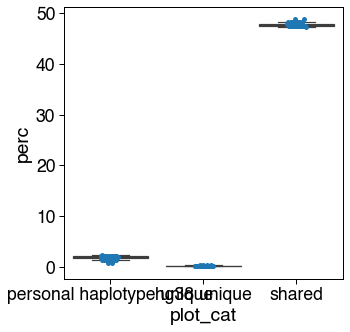

In [78]:
# sns.displot(big_df, x='perc', hue='plot_cat', kind='kde', common_norm=False)
# sns.boxplot(big_df, y='perc', hue='plot_cat', kind='kde', common_norm=False)

sns.boxplot(x='plot_cat', y='perc', data=big_df, showfliers=False)
sns.stripplot(x='plot_cat', y='perc', data=big_df, jitter=True)

In [73]:
med_shared = big_df.loc[big_df.plot_cat=='shared', 'perc'].median()
print(f'Median of {med_shared}% ICs are shared between each personal haplotype and hg38')

Median of 95.20212779566577% ICs are shared between each personal haplotype and hg38


<AxesSubplot:xlabel='plot_cat', ylabel='perc'>

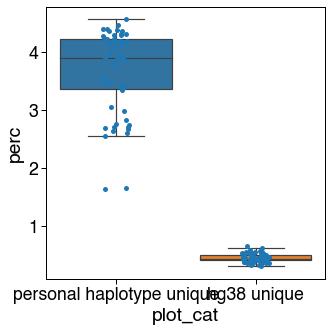

In [70]:
init_plot_settings()
temp = big_df.loc[big_df.plot_cat.isin(['personal haplotype unique', 'hg38 unique'])]
sns.boxplot(x='plot_cat', y='perc', data=temp, showfliers=False)
ax =sns.stripplot(x='plot_cat', y='perc', data=temp, jitter=True)
ax.set(xlabel='', ylabel='% total ICs')

## Do we get more NNC (novel splice site) when we look at the personal haploytpes versus the hg38?